In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
ver = tf.__version__
print("Tensor Flow version {}".format(ver))

Tensor Flow version 1.14.0


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Number of samples 55000 Shape of y[(55000, 10)] Shape of X[(55000, 784)]


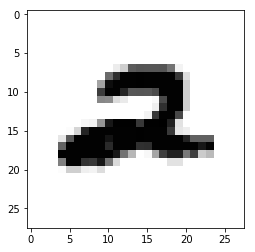

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
print("Number of samples {} Shape of y[{}] Shape of X[{}]"
      .format(n_samples, mnist.train.labels.shape, mnist.train.images.shape))
plt.imshow(np.reshape(-mnist.train.images[4242], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))

In [0]:
def weights(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [0]:
# Encoder Network

n_z = 2 #Dimension of the latent space
# Input
x = tf.placeholder("float", shape=[None, 28*28]) #Batchsize x Number of Pixels
y_ = tf.placeholder("float", shape=[None, 10])   #Batchsize x 10 (one hot encoded)

# First hidden layer
W_fc1 = weights([784, 500])
b_fc1 = bias([500])
h_1   = tf.nn.softplus(tf.matmul(x, W_fc1) + b_fc1)

# Second hidden layer 
W_fc2 = weights([500, 501]) #501 and not 500 to spot errors
b_fc2 = bias([501])
h_2   = tf.nn.softplus(tf.matmul(h_1, W_fc2) + b_fc2)

# Parameters for the Gaussian
z_mean = tf.add(tf.matmul(h_2, weights([501, n_z])), bias([n_z]))
z_log_sigma_sq = tf.add(tf.matmul(h_2, weights([501, n_z])), bias([n_z]))

In [0]:
# Decoder Network

batch_size = 64
epsilon = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32) # Adding a random number
z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), epsilon))  # The sampled z

In [0]:
W_fc1_g = weights([n_z, 500])
b_fc1_g = bias([500])
h_1_g   = tf.nn.softplus(tf.matmul(z, W_fc1_g) + b_fc1_g)

W_fc2_g = weights([500, 501])
b_fc2_g = bias([501])
h_2_g   = tf.nn.softplus(tf.matmul(h_1_g, W_fc2_g) + b_fc2_g)

x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(h_2_g,  weights([501, 784])), bias([784])))
x_reconstr_sigma = tf.nn.sigmoid(tf.add(tf.matmul(h_2_g, weights([501, 784])), bias([784])))

In [0]:
# Defining Loss function

reconstr_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_reconstr_mean) + (1-x) * tf.log(1e-10 + 1 - x_reconstr_mean), 1)
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)
cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch

# Use ADAM optimizer
optimizer =  tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [0]:
# Training the network

runs = 20 #Set to 0, for no training
init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    batch_xs, _ = mnist.train.next_batch(batch_size)
    print(batch_xs.shape)
    dd = sess.run([cost], feed_dict={x: batch_xs})
    print('Test run after starting {}'.format(dd))

    for epoch in range(runs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            _,d = sess.run((optimizer, cost), feed_dict={x: batch_xs})
            avg_cost += d / n_samples * batch_size

        # Display logs per epoch step
        if epoch % 1 == 0:
            save_path = saver.save(sess, "/content/gdrive/My Drive/model/VAE Kingma and Welling.ckpt") # Saves the weights (not the graph)
            print("Model saved in file: {}".format(save_path))
            print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

(64, 784)
Test run after starting [989.4016]
Model saved in file: /content/gdrive/My Drive/model/VAE Kingma and Welling.ckpt
Epoch: 0001 cost= 182.960226651
Model saved in file: /content/gdrive/My Drive/model/VAE Kingma and Welling.ckpt
Epoch: 0002 cost= 165.845423668
Model saved in file: /content/gdrive/My Drive/model/VAE Kingma and Welling.ckpt
Epoch: 0003 cost= 161.147007315
Model saved in file: /content/gdrive/My Drive/model/VAE Kingma and Welling.ckpt
Epoch: 0004 cost= 157.853237163
Model saved in file: /content/gdrive/My Drive/model/VAE Kingma and Welling.ckpt
Epoch: 0005 cost= 155.592710600
Model saved in file: /content/gdrive/My Drive/model/VAE Kingma and Welling.ckpt
Epoch: 0006 cost= 153.915787820
Model saved in file: /content/gdrive/My Drive/model/VAE Kingma and Welling.ckpt
Epoch: 0007 cost= 152.620604634
Model saved in file: /content/gdrive/My Drive/model/VAE Kingma and Welling.ckpt
Epoch: 0008 cost= 151.581166442
Model saved in file: /content/gdrive/My Drive/model/VAE Kin

In [0]:
check_point_file = "/content/gdrive/My Drive/model/VAE Kingma and Welling.ckpt"

Model restored.


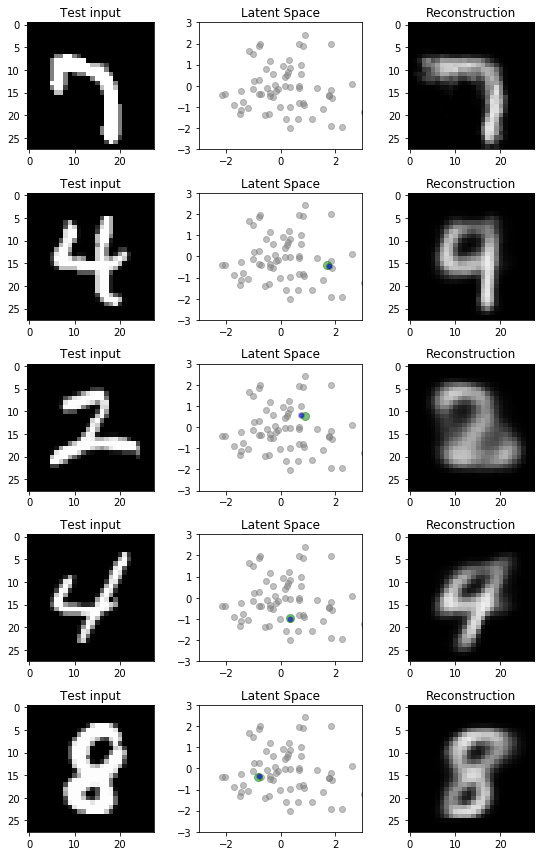

In [0]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    print("Model restored.")
    x_sample = mnist.test.next_batch(64)[0]
    x_reconstruct,x_reconstr_sigma_val,z_vals,z_mean_val,z_log_sigma_sq_val  = sess.run((x_reconstr_mean,x_reconstr_sigma,z, z_mean, z_log_sigma_sq), feed_dict={x: x_sample})

    plt.figure(figsize=(8, 12))
    for i in range(5):
        plt.subplot(5, 3, 3*i + 1)
        plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Test input")
        
        #plt.colorbar()
        plt.subplot(5, 3, 3*i + 2)
        plt.scatter(z_vals[:,0],z_vals[:,1], c='gray', alpha=0.5)
        plt.scatter(z_mean_val[i,0],z_mean_val[i,1], c='green', s=64, alpha=0.5)
        plt.scatter(z_vals[i,0],z_vals[i,1], c='blue', s=16, alpha=0.5)
       
        plt.xlim((-3,3))
        plt.ylim((-3,3))
        plt.title("Latent Space")
        
        plt.subplot(5, 3, 3*i + 3)
        plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Reconstruction")
        #plt.colorbar()
    plt.tight_layout()

In [0]:

np.mean(z_mean_val)
np.mean(np.sqrt(np.exp(x_reconstr_sigma_val)))

1.3071077

In [0]:
np.mean(np.sqrt(np.exp(z_log_sigma_sq_val))) #Usually the choosen sigma is quite small

0.054911256

Model restored.


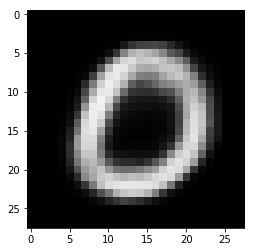

In [0]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    print("Model restored.")
    d = np.zeros([batch_size,2],dtype='float32')
    d[0,] = [1,2]
    x_reconstruct = sess.run(x_reconstr_mean, feed_dict={z: d})
    plt.imshow(x_reconstruct[0].reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))

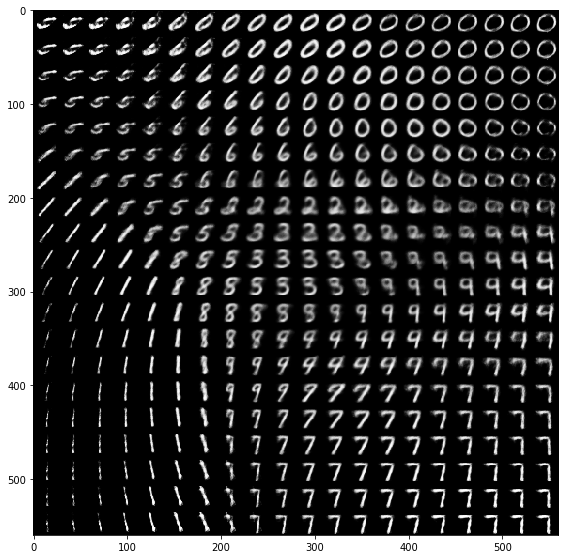

In [0]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            z_mu = np.array([[xi, yi]])
            d[0] = z_mu
            x_mean = sess.run(x_reconstr_mean, feed_dict={z: d})
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()

In [0]:
# Latent DIstribution of the P(z|x) of the training set

saver = tf.train.Saver()
all_z = np.zeros((1,2))
with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        x_reconstruct,z_vals,z_mean_val,z_log_sigma_sq_val  = \
        sess.run((x_reconstr_mean,z, z_mean, z_log_sigma_sq), feed_dict={x: batch_xs})
        all_z = np.vstack((all_z, z_mean_val))

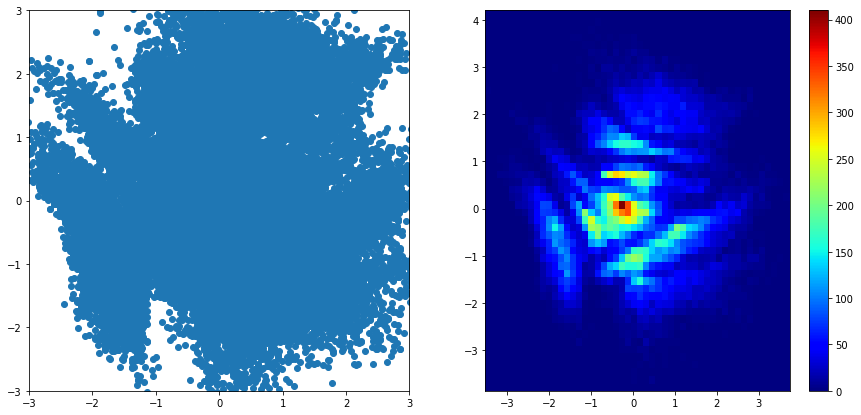

In [0]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.scatter(all_z[:,0], all_z[:,1])
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.subplot(1,2,2)
plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
plt.colorbar()